### Neural Graph Revealers for recovering conditional independence graphs 

- We design a synthetic experiment to study the capability of `Neural Graph Revealers` to recover conditional independence graph represented by Gaussian graphical models.  
- The input data X is sampled from a multivariate Gaussian distribution where we define the underlying precision matrix.   
- Run `NGRs` to recover the underlying graph between features that should ideally match the CI graph.

In [1]:
import os, sys
# reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
print(sys.prefix)
import warnings
warnings.filterwarnings('ignore')

import pickle

/anaconda/envs/ngm


### Setup the Gaussian graphical model
1. Initialize a graph type.
2. Get the precision matrix `theta` and corresponding samples `X` from a multivariate Gaussian distribution.
3. Get the partial correlations matrix `rho` and the graph `G`.

In [15]:
import numpy as np
import pandas as pd

# Local imports
from ngr.utils import ggm
from ngr.utils import data_processing as dp
# from uGLAD.utils.metrics import reportMetrics

# Xb = samples batch, trueTheta = corresponding true precision matrices
Xb, true_theta = ggm.get_data(
    num_nodes=10, 
    typeG='CHAIN', 
    sparsity=[0.2, 0.2], # Not used for chain graph
    num_samples=5000, 
    batch_size=1,
    eig_offset=0.1,#0.1, 
    w_min=0.5,
    w_max=1
)
X, true_theta =Xb[0], true_theta[0]
# set the column names for X
X = pd.DataFrame(X, columns=['n'+str(i) for i in range(X.shape[1])])
rho = ggm.get_partial_correlations(true_theta)
print(f'partial correlations: {rho.shape}, Samples {X.shape}')
G, image_G, graph_edge_list = ggm.graph_from_partial_correlations(rho, X.columns)

partial correlations: (10, 10), Samples (5000, 10)
Sparsity 1 using threshold 0.0


In [16]:
Gv = dp.get_interactive_graph(G, 'GGM Chain graph', node_PREFIX=None)
Gv.show('viz_ggm.html')

In [17]:
X

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9
0,0.767268,-0.979659,1.046004,-1.461619,2.175090,0.612038,-0.961096,-0.488278,-0.523504,0.482449
1,-0.700237,1.103611,-1.981097,-0.954230,1.740229,-2.486970,2.651465,-0.129854,-0.750695,0.633747
2,0.017644,-0.089878,0.233597,1.380079,-0.281326,-1.392009,2.614993,-2.365668,-1.900025,1.121979
3,0.229520,-1.613814,1.032766,-1.351961,0.929709,-0.680311,0.611566,-0.434841,-0.708244,0.446975
4,-0.406019,0.153366,0.848791,0.197184,0.321513,0.599608,-0.825687,-0.209009,2.076419,-1.607562
...,...,...,...,...,...,...,...,...,...,...
4995,0.910778,0.016850,0.895106,0.034905,-0.647549,-0.387837,-0.157419,0.681538,0.486042,0.659767
4996,-0.592355,0.232038,0.895845,1.527587,-1.651451,-0.592704,-0.777851,-1.373095,-0.282867,-0.796989
4997,0.800201,-1.249396,-1.389241,-1.872950,1.396386,-0.913982,-1.271593,1.244957,-0.306986,-0.119172
4998,-0.232420,-0.409884,1.521734,0.914500,1.109547,-1.868056,1.136559,0.187382,0.890733,0.941072


### Neural graph revealer

For faster runtimes, set USE_CUDA=True

In [83]:
import pandas as pd
import ngr.main as ngr
import ngr.utils.data_processing as dp

# Learning the NMG model
model_NGR = ngr.recover_graph(
    X, lambd=1e2,
    hidden_dim=100,
    epochs=50000, 
    lr=0.0005, #0.0005,
    norm_type='min_max',
    k_fold=1,
    structure_penalty='hadamard',
    VERBOSE=True, 
    BATCH_SIZE=None#5000, #1000
) 
# NOTE 
# Divide into batches
# Stop training when train & test loss are low and the values are comparable. 

Means of selected features (n0   -0.008072
n1    0.029049
n2   -0.025730
n3   -0.017546
n4    0.008463
n5   -0.007317
n6    0.007216
n7    0.005749
n8    0.027568
n9   -0.008732
dtype: float64, 10)
Normalizing the data: min_max
: Processing the input table for basic compatibility check
: The input table has sample 5000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
: The processed table has sample 5000 and features 10
: Total time to process the table 0.009 secs
Fold num 0
Initializing the NGM model

Fold 0: epoch:0/50000
Train: loss=3.941802501678467, reg=0.21723893284797668, struct=0.03724563494324684
Test: loss=3.941396713256836, reg=0.2168331891298294, struct=0.03724563494324684

Fold 0: epoch:5000/50000
Train: loss=1.3709419965744019, reg=0.014775952324271202, struct=0.013561660423874855
Test: loss=1.371002197265625, reg=0.014836198650300503, struct=0.013561660423874855

Fold 0: epoch:10000/50000
Train: loss=1.0552412271499634, r

In [84]:
import networkx as nx
# Plot the graph
def adjust_graph_sparsity(G_in, sparsity=1, roundOFF=4):
    G = nx.Graph() # G_out 
    names = np.array(G_in.nodes())
    G.add_nodes_from(names)
    rho = np.array(nx.adjacency_matrix(G_in).todense())
    D = rho.shape[-1]
    
    # determining the threshold to maintain the sparsity level of the graph
    def upper_tri_indexing(A):
        m = A.shape[0]
        r,c = np.triu_indices(m,1)
        return A[r,c]

    rho_upper = upper_tri_indexing(np.abs(rho))
    num_non_zeros = int(sparsity*len(rho_upper))
    rho_upper.sort()
    th = rho_upper[-num_non_zeros]
    print(f'Sparsity {sparsity} using threshold {th}')
    th_pos, th_neg = th, -1*th

    for i in range(D):
        for j in range(i+1, D):
            if rho[i,j] > th_pos:
                G.add_edge(names[i], names[j], color='green', weight=round(rho[i,j], roundOFF), label='+')
            elif rho[i,j] < th_neg:
                G.add_edge(names[i], names[j], color='red', weight=round(rho[i,j], roundOFF), label='-')
    return G

def get_graph_NGR(model_NGR, sparsity=1):
    model, scaler, feature_means = model_NGR
    # Get the dependency matrix
    prod_W = dp.t2np(ngr.product_weights_MLP(model))
    # Get the adjacency matrix (symmetric)
    adj = (prod_W + np.transpose(prod_W))/2.0
    # adj=prod_W
    G = nx.from_numpy_matrix(adj)
    # add node names
    mapping = {i:f for i, f in enumerate(feature_means.index)}
    G = nx.relabel_nodes(G, mapping)
    # adjust sparsity
    G = adjust_graph_sparsity(G, sparsity=sparsity)
    return G
G_ngr = get_graph_NGR(model_NGR)
Gv_ngr = dp.get_interactive_graph(G_ngr, 'NGR graph', node_PREFIX=None)
Gv_ngr.show('viz_ngr.html')

Sparsity 1 using threshold 7.490377174690366e-05


### Comparison 

In [85]:
# Comparing with true precision matrix
from ngr.utils.metrics import graph_compare_metrics

true_adj = np.array(nx.adjacency_matrix(G).todense())
ngr_adj = np.array(nx.adjacency_matrix(G_ngr).todense())
compare_results = graph_compare_metrics(
    true_adj, 
    ngr_adj # Compare with sparsity=1
)
compare_results

{'FDR': 0.7954545454545454,
 'TPR': 1.0,
 'FPR': 0.9722222222222222,
 'SHD': 35,
 'nnzTrue': 9,
 'nnzPred': 44,
 'precision': 0.20454545454545456,
 'recall': 1.0,
 'Fbeta': 0.33962264150943394,
 'aupr': 0.6611531986531987,
 'auc': 0.8935185185185185}

In [86]:
true_adj, ngr_adj

(array([[ 0.     , -0.41414,  0.     ,  0.     ,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [-0.41414,  0.     , -0.51723,  0.     ,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     , -0.51723,  0.     ,  0.51071,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.51071,  0.     , -0.53717,  0.     ,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     , -0.53717,  0.     , -0.45504,
          0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     , -0.45504,  0.     ,
         -0.46132,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.46132,
          0.     , -0.43777,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         -0.43777,  0.     ,  0.45872,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,

In [87]:
true_theta

array([[ 1.56978363,  0.65011137,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.65011137,  1.56978363,  0.81194615,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.81194615,  1.56978363, -0.80170829,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.80170829,  1.56978363,  0.84323387,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.84323387,  1.56978363,
         0.71431432,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.71431432,
         1.56978363,  0.72416986,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.72416986,  1.56978363,  0.68720719

#### GGM
Can be shown analytically 

Features dropped from graph: set()
target=n5, source=n4
target=n5, source=n6


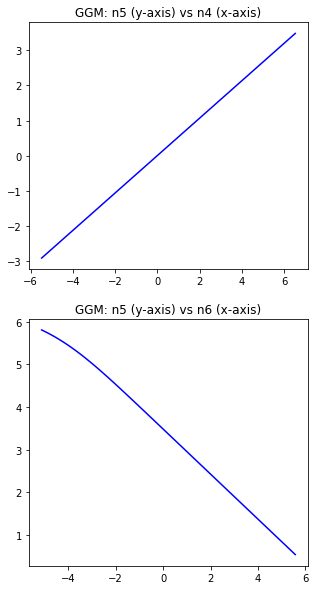

In [86]:
# Local imports
from ngm.utils import ggm

# Define the mean and cov of the multivariate Gaussian
data_min_ = X.min(axis=0)
data_max_ = X.max(axis=0)
_scaler = [data_min_, data_max_]
D = true_theta.shape[0]
mean = pd.Series(np.zeros(D), index=X.columns)
cov=np.linalg.pinv(true_theta)

# Analyse the feature dependency functions
ggm.analyse_feature(feature_of_interest, [mean, cov, _scaler], G, Xi=mean)

#### NGM

Features dropped from graph: set()
target=n5, source=n4
target=n5, source=n6


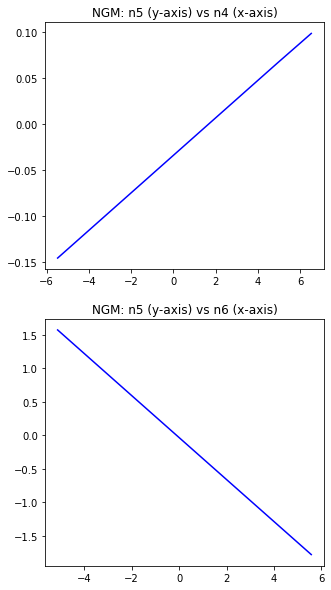

In [87]:
# Analyse the distribution details of the feature of interest
ngm.analyse_feature(feature_of_interest, model_NGM, G, dp.series2df(mean))

### NGM: Sampling

In [ ]:
import ngm.main as ngm

Xs = ngm.sampling(model_NGM, G, num_samples=4000, max_infer_itr=2)
Xs = Xs[X.columns]

### Run CI graph recovery algorithms
1. uGLAD
2. BCD

In [68]:
# uGLAD
from ngm.utils.uGLAD import main as uG
from ngm.utils.metrics import reportMetrics

# Initialize the model
model_uGLAD = uG.uGLAD_GL()  

Xs = Xs[X.columns]
# Fit to the data
model_uGLAD.fit(
    Xs,
    centered=False,
    epochs=2000,
    lr=0.001,
    INIT_DIAG=0,
    L=5,
    verbose=True, 
    k_fold=0,  # Direct mode
    mode='direct'
)  

# Comparing with true precision matrix
compare_theta_uGLAD = reportMetrics(
        true_theta, 
        model_uGLAD.precision_
    )
print(f'uGLAD: {compare_theta_uGLAD}')

Running uGLAD
Processing the input table for basic compatibility check
: Processing the input table for basic compatibility check
: The input table has sample 4000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
Input covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: Duplicates dropped: total 0, columns []
: Low Variance columns dropped: min variance 0.0,        total 0, columns []
Processed covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: The processed table has sample 4000 and features 10
: Total time to process the table 0.852 secs
Direct Mode
epoch:0/2000 loss:-12.358485221862793
epoch:200/2000 loss:-15.940261840820312
epoch:400/2000 loss:-20.333969116210938
epoch:600/2000 loss:-25.18743133544922
epoch:800/2000 loss:-37.673797607421875
epoch:1000/2000 loss:-37.6756591796875
epoch:1200/20

In [82]:
def viz_graph_from_precision(theta):
    rho = ggm.get_partial_correlations(theta)
    Gr, _, _ = ggm.graph_from_partial_correlations(
        rho, 
        Xs.columns,
        sparsity=0.3
    )
    Gv = dp.get_interactive_graph(Gr, 'CI graph recovered from NGM samples', node_PREFIX=None)
    return Gv
    

In [83]:
Gv = viz_graph_from_precision(model_uGLAD.precision_)
Gv.show('viz_ggm_from_ngm_samples.html')

Sparsity 0.3 using threshold 0.05290000024270138
